## Setup

In [1]:
import numpy as np
import pandas as pd

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(style="darkgrid")

from nltk.translate.bleu_score import sentence_bleu

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5



This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [3]:
use_builtins = True

В этом руководстве используется множество низкоуровневых API, где легко ошибиться с формами. Этот класс используется для проверки форм на протяжении всего урока.

In [4]:
class ShapeChecker():
    def __init__(self):
    # Сохранение кэш всех видимых имен осей
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                             f"    found: {new_dim}\n"
                             f"    expected: {old_dim}\n")

# Загрузка данных

In [5]:
def load_data(path):
    with open(path, encoding='utf-8') as f:
        text = f.read()

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    source = [source for source, target in pairs]
    target = [target for source, target in pairs]

    return source, target

In [6]:
path = 'rus-eng-mini'
path_to_file = f'Date/{path}.txt'
source, target = load_data(path_to_file)

In [7]:
data = pd.DataFrame()
data['Source'] = source
data['Target'] = target

In [8]:
data.head()

,Source,Target
0,Марш!,Go.
1,Иди.,Go.
2,Идите.,Go.
3,Здравствуйте.,Hi.
4,Привет!,Hi.


In [9]:
data.tail()

,Source,Target
99995,Я этого не выношу.,I can't tolerate that.
99996,Я не могу дотронуться до пальцев ног.,I can't touch my toes.
99997,Я никому не могу верить.,I can't trust anybody.
99998,Я никому не могу доверять.,I can't trust anybody.
99999,Я пока не могу тебе доверять.,I can't trust you yet.


## Создайте набора данных

In [10]:
BUFFER_SIZE = len(source)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((source, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5].numpy())
    print()
    print(example_target_batch[:5].numpy())
    break

[b'\xd0\xa3 \xd0\xbc\xd0\xb5\xd0\xbd\xd1\x8f \xd0\xb1\xd0\xbe\xd1\x82\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb8 \xd1\x81\xd0\xba\xd1\x80\xd0\xb8\xd0\xbf\xd1\x8f\xd1\x82.'
 b'\xd0\xaf \xd0\xbd\xd0\xb5 \xd1\x81\xd0\xb4\xd0\xb0\xd0\xbc\xd1\x81\xd1\x8f.'
 b'\xd0\xa2\xd1\x8b \xd1\x83\xd0\xb1\xd0\xb8\xd0\xbb \xd0\xa2\xd0\xbe\xd0\xbc\xd0\xb0.'
 b'\xd0\xa2\xd1\x8b \xd0\xbf\xd0\xbe\xd1\x81\xd1\x82\xd0\xb0\xd0\xb2\xd0\xb8\xd0\xbb \xd1\x81\xd0\xb2\xd0\xbe\xd1\x8e \xd0\xbf\xd0\xbe\xd0\xb4\xd0\xbf\xd0\xb8\xd1\x81\xd1\x8c?'
 b'\xd0\x9a\xd1\x82\xd0\xbe \xd1\x80\xd0\xb0\xd0\xb7\xd0\xb1\xd0\xb8\xd0\xbb \xd0\xb2\xd0\xb0\xd0\xb7\xd1\x83?']

[b'My shoes squeak.' b"I won't give up." b'You killed Tom.'
 b'Did you sign?' b'Who broke the vase?']


## Предварительная обработка текста

Одна из целей этого руководства - создать модель, которую можно экспортировать как `tf.saved_model`. Чтобы сделать эту экспортированную модель полезной, она должна принимать входные данные `tf.string` и возвращать выходные данные `tf.string`: вся обработка текста происходит внутри модели.

### Стандартизация

Модель имеет дело с многоязычным текстом с ограниченным словарным запасом. Поэтому будет важно стандартизировать вводимый текст.

Первым шагом является нормализация Юникода для разделения символов с акцентом и замены символов совместимости их эквивалентами в формате ASCII.

Пакет `tensorflow_text` содержит операцию нормализации в юникоде:

In [12]:
example_text = tf.constant('Æз? Мæ ном хуыйны Алан.')

print(example_text.numpy().decode())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode())

Æз? Мæ ном хуыйны Алан.
Æз? Мæ ном хуыйны Алан.


Unicode normalization will be the first step in the text standardization function:

In [13]:
def to_lower_case_eng(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 65), tf.less(chars, 91))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [14]:
def to_lower_case_rus(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 1040), tf.less(chars, 1072))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [15]:
def to_lower_case_oss(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 198), tf.less(chars, 199))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [16]:
def tf_lower_and_split_punct(text):
    # Замена символов 'æ' с кодом 1237 на символ 'æ' с кодом 230
    text = tf.strings.regex_replace(text, 'ӕ', 'æ')
    # Замена символа '—' на '-'
    text = tf.strings.regex_replace(text, '—', '-')
    
    text = tf_text.normalize_utf8(text, 'NFKD')
    
    # Нижний регистр
    text = to_lower_case_rus(text)
    text = to_lower_case_eng(text)
    text = to_lower_case_oss(text)
    
    # Удаление лишних символов, кроме списка представленных.
    text = tf.strings.regex_replace(text, '[^ a-zа-яæ.?!,-`…:;\']', '')
    # Добавьте пробелы вокруг знаков препинания.
    text = tf.strings.regex_replace(text, '[.?!,-`…:;\']', r' \0 ')
    # Удаление лишних пробелов.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [17]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Æз? Мæ ном хуыйны Алан.
[START] æз ?  мæ ном хуыины алан . [END]


### Векторизация текста

Эта функция стандартизации находится в `tf.keras.layers.TextVectorization`, который будет обрабатывать получение словаря и преобразование входного текста в последовательности токенов.

In [18]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

Слой `TextVectorization` и многие другие слои предварительной обработки имеют метод `adapt`. Этот метод считывает одну эпоху обучающих данных и работает очень похоже на `Model.fix`. Этот метод `adapt` инициализирует слой на основе данных. Здесь он определяет словарный запас:

In [19]:
input_text_processor.adapt(source)

# Первые 10 слов из входного словаря
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'я', '?', 'том', 'не', 'это']

In [20]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Первые 10 слов из выходного словаря
output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', "'", 'i', 'tom', 'you', '?']

Теперь эти слои могут преобразовывать пакет строк в пакет идентификаторов токенов:

In [21]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2,  15,  17, 503,   1,   4,   3,   0,   0,   0],
       [  2,   5,   8,   1,   4,   3,   0,   0,   0,   0],
       [  2,  11, 694,  19,   4,   3,   0,   0,   0,   0]], dtype=int64)>

Метод `get_vocabulary` можно использовать для преобразования идентификаторов токенов обратно в текст:

In [22]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] у меня ботинки [UNK] . [END]   '

Возвращаемые идентификаторы токенов заполняются нулем. Это можно легко превратить в маску:

Text(0.5, 1.0, 'Mask')

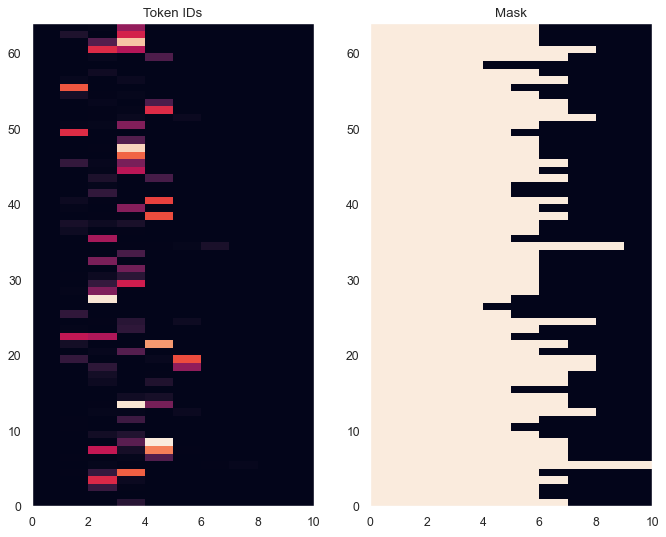

In [23]:
plt.figure(figsize=(10,8), dpi=80)
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

# Поссстроение модели

Прежде чем приступить к этому, определите несколько констант для модели:

In [24]:
embedding_dim = 256
units = 1024

## Encoder

Энкодер включает в себя:

1. Принимает список идентификаторов токенов (`input_text_processor`).
2. Ищет Embedding вектор для токенов (`layers.Embedding`).
3. Обробатывает Embedding в новую последовательность (`layers.GRU`).
4. Возвращает:
    * Обработанная последовательность. Это будет передано слою Attention.
    * Внутреннее состояние. Это будет использовано для инициализации декодера

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # Слой Embedding преобразует токены в векторы
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        # Слой GRU для обработки входных векторов
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       # Возвращает последовательность и состояние
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. Слой Embedding просматривается для каждого токена.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. GRU обрабатывает последовательность embedding'a.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Возвращает новую последовательность и ее состояние.
        return output, state

In [26]:
# Преобразование входного текста в токены.
example_tokens = input_text_processor(example_input_batch)

# Закодирование входной последовательности
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 10)
Encoder output, shape (batch, s, units): (64, 10, 1024)
Encoder state, shape (batch, units): (64, 1024)


Энкодер возвращает свое внутреннее состояние, чтобы его состояние можно было использовать для инициализации декодера.

Также обычно RNN возвращает свое состояние, чтобы он мог обрабатывать последовательность по нескольким вызовам. Вы увидите больше об этом при создании декодера.

## Attention

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

## Проверка слоя Attention

In [28]:
attention_layer = BahdanauAttention(units)

In [29]:
(example_tokens != 0).shape

TensorShape([64, 10])

In [30]:
# Позже декодер сгенерирует этот запрос внимания
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Обратите внимание на закодированные токены

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 10)


Text(0.5, 1.0, 'Mask')

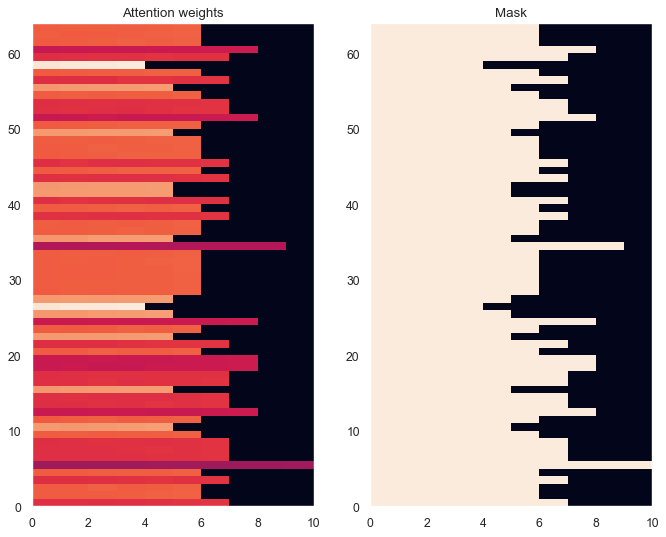

In [31]:
plt.figure(figsize=(10,8), dpi=80)
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [32]:
attention_weights.shape

TensorShape([64, 2, 10])

In [33]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 800x640 with 0 Axes>

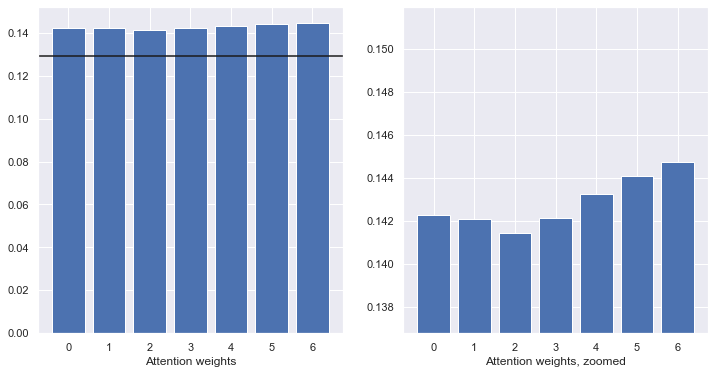

In [34]:
#@title
plt.figure(figsize=(10,8), dpi=80)
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

## Decoder

In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [36]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [37]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [38]:
Decoder.call = call

In [39]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [40]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [41]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [43]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['usual'],
       ['girl'],
       ['smokes'],
       ['school'],
       ['confided']], dtype='<U15')

In [44]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [45]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['flinch'],
       ['humiliating'],
       ['cries'],
       ['risked'],
       ['fly']], dtype='<U15')

# Training

## Define the loss function

In [46]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

## Implement the training step

In [47]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [48]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [49]:
TrainTranslator._preprocess = _preprocess

In [50]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
          # Pass in two tokens from the target sequence:
          # 1. The current input to the decoder.
          # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                 enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [51]:
TrainTranslator._train_step = _train_step

In [52]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [53]:
TrainTranslator._loop_step = _loop_step

## Test the training step

In [54]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [55]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [56]:
%%time
for n in range(25):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3443933>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.303845>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2225924>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.9909472>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.2436094>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.382461>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.296393>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7538168>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.599088>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4845>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4480476>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4446545>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3915956>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3194811>}
{'batch_loss': <tf.Tensor: 

In [57]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [58]:
TrainTranslator._tf_train_step = _tf_train_step

In [59]:
translator.use_tf_function = True

In [60]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7816298>}

In [61]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.764896>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.740348>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7264273>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6984413>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6796947>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6510715>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6338253>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6119046>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.5947464>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.5758202>}
Wall time: 2.15 s


....................................................................................................

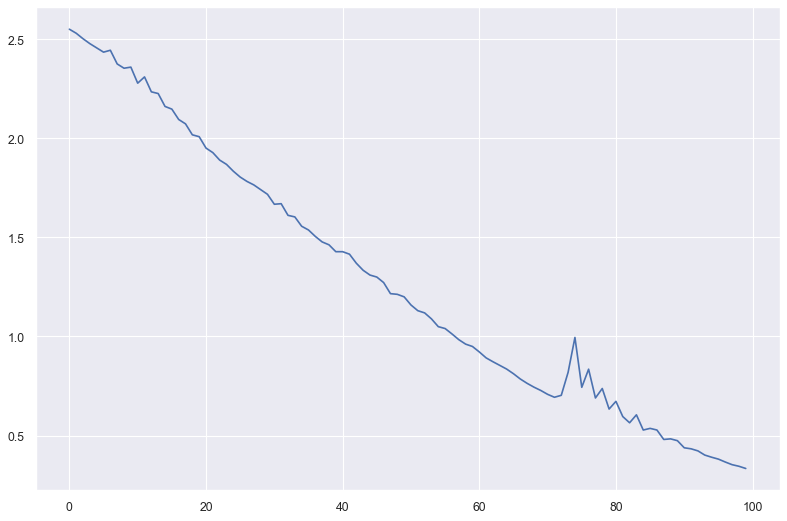

In [62]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

plt.figure(figsize=(12,8), dpi=80)
plt.plot(losses)

In [103]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=['accuracy']
)

## Train the model

In [104]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [105]:
epochs=5

In [106]:
train_translator.fit(dataset, epochs=epochs, callbacks=[batch_loss])

Epoch 1/5
1563/1563 [==============================] - 386s 237ms/step - batch_loss: 1.5589
Epoch 2/5
1563/1563 [==============================] - 377s 241ms/step - batch_loss: 0.6831
Epoch 3/5
1563/1563 [==============================] - 372s 238ms/step - batch_loss: 0.5220
Epoch 4/5
1563/1563 [==============================] - 371s 238ms/step - batch_loss: 0.4344
Epoch 5/5
1563/1563 [==============================] - 373s 238ms/step - batch_loss: 0.3754


Text(0, 0.5, 'CE/token')

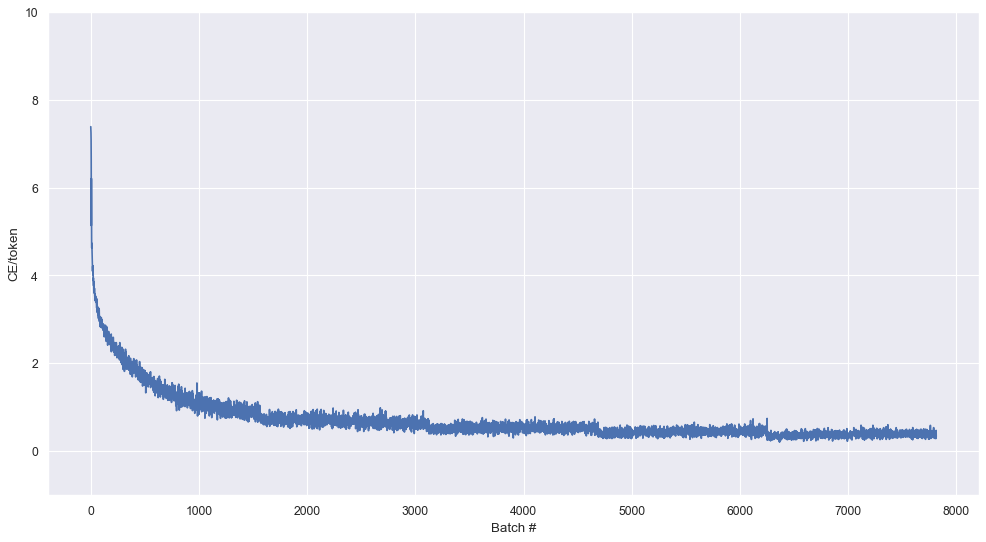

In [107]:
plt.figure(figsize=(15,8), dpi=80)
plt.plot(batch_loss.logs)
plt.ylim([-1, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

# Translate

In [68]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [69]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/4173397781.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


## Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [70]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [71]:
Translator.tokens_to_text = tokens_to_text

In [72]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'sleeve mama', b'tokyo signal', b'nowhere use', b'spanish aid',
       b'american insulted'], dtype=object)

## Sample from the decoder's predictions

In [73]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature, num_samples=1)
        
    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens

In [74]:
Translator.sample = sample

In [75]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 123],
       [3063],
       [ 865],
       [ 888],
       [3707]], dtype=int64)>

## Implement the translation loop

In [76]:
def translate_unrolled(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                 enc_output=enc_output,
                                 mask=(input_tokens!=0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}


In [77]:
Translator.translate = translate_unrolled

In [78]:
%%time
input_text = tf.constant([
    'Как дела?', # "It's really cold here."
    'Доброе утро!', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

how ' s it going ?
good morning .

Wall time: 270 ms


In [79]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

In [80]:
%%time
result = translator.tf_translate(input_text = input_text)

Wall time: 21 s


In [81]:
%%time
# result = translator.tf_translate(
#     input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

how is your stay ?
good morning !

Wall time: 977 µs


In [82]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

how ' s it going ?
good morning .

Wall time: 275 ms


In [83]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

In [84]:
%%time
result = translator.tf_translate(
    input_text = input_text)

Wall time: 21.3 s


In [85]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

how is it going ?
good morning .

Wall time: 279 ms


In [86]:
result['text']

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'how is it going ?', b'good morning .'], dtype=object)>

## Visualize the process

In [87]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[0.9999999  1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999994 0.99999994 1.         1.         1.         0.99999994
 0.99999994 0.99999994 1.0000001  1.         1.0000001  1.
 0.99999994 1.         1.         0.99999994 1.         1.
 1.         0.99999994 1.         1.         1.0000001  0.9999999
 1.         1.         0.9999999  1.         1.         1.
 1.         1.         1.         0.99999994 0.99999994 0.9999999
 1.         1.        ]


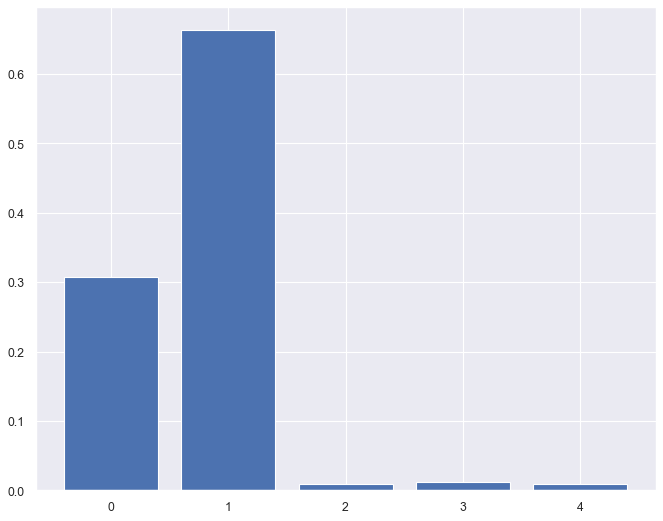

In [88]:
plt.figure(figsize=(10,8), dpi=80)
_ = plt.bar(range(len(a[0, :])), a[0, :])

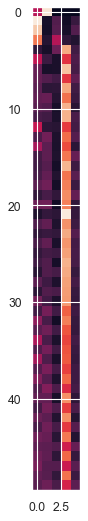

In [89]:
plt.figure(figsize=(10,8), dpi=80)
plt.imshow(np.array(a), vmin=0.0)

In [90]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
    plt.figure(figsize=(10,8), dpi=80)
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

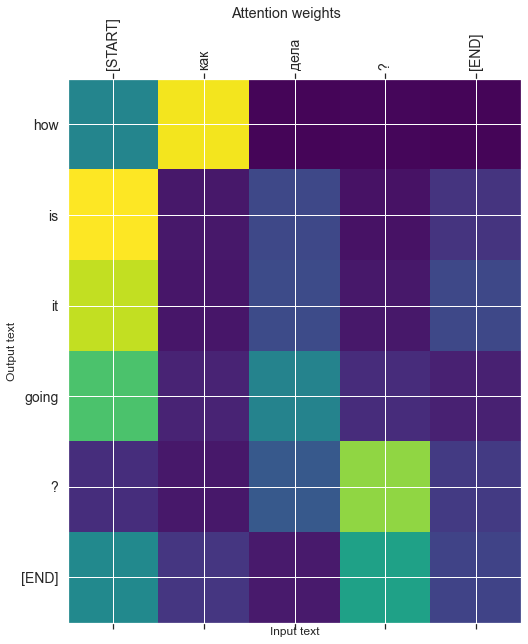

In [91]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [92]:
%%time
three_input_text = tf.constant([
    'Как дела?',
    'Как дела?',
    'Ты дома?',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

how are you doing ?
how is it going ?
are you home ?

Wall time: 129 ms


In [93]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'how are you doing ?', b'how is it going ?', b'are you home ?'],
      dtype=object)>

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

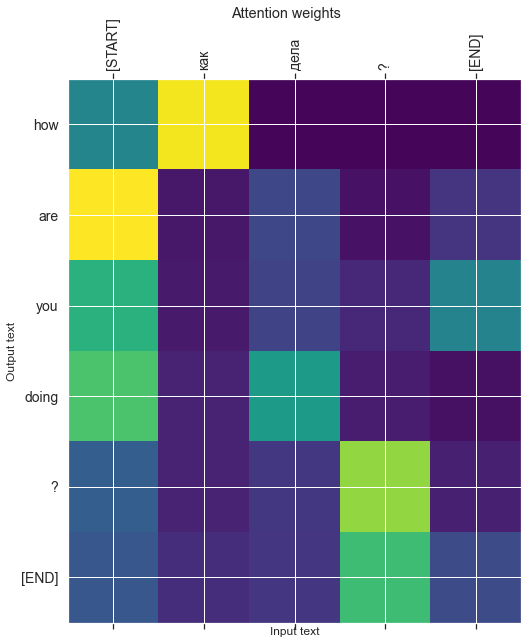

In [94]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

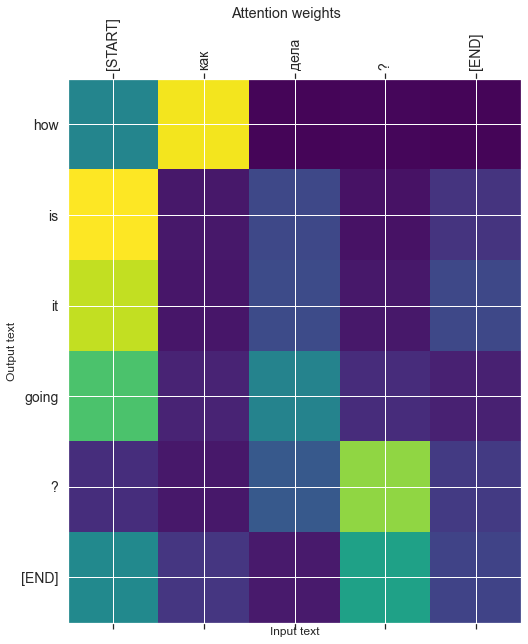

In [95]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

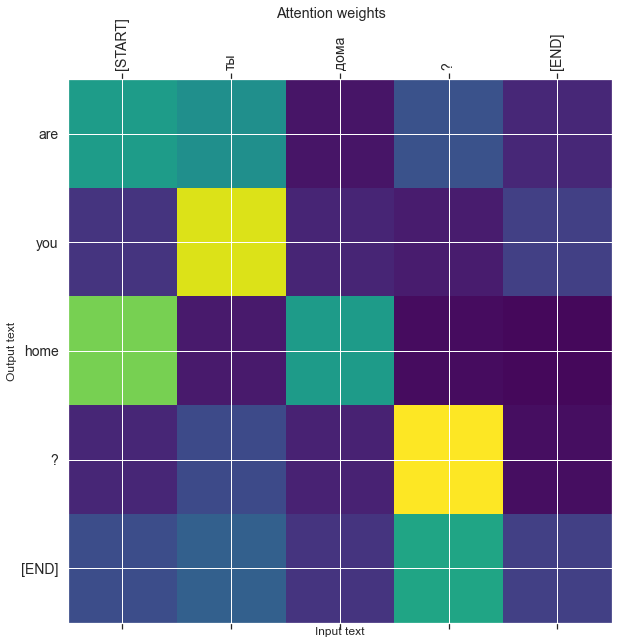

In [96]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [97]:
long_input_text = tf.constant([source[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target[-1])))

Expected output:
 I can't trust you yet.


C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_10424/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

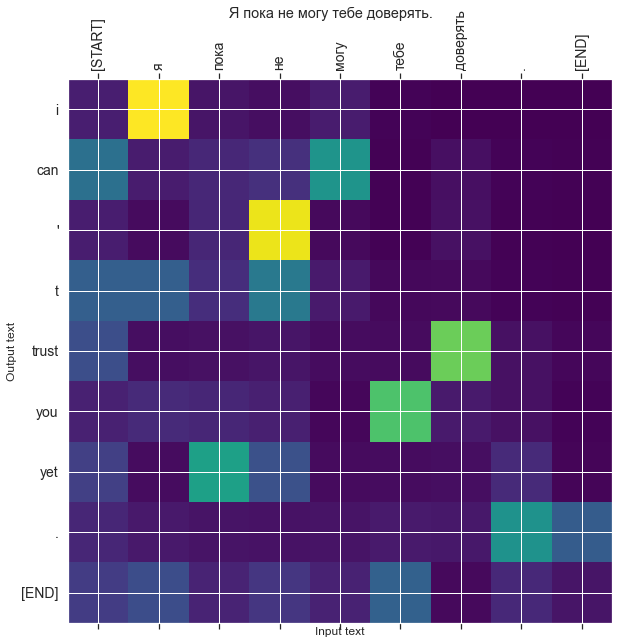

In [98]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('Я пока не могу тебе доверять.')

# Export

In [108]:
tf.saved_model.save(translator, f'{path.upper()} GRU-[{units}]-Epochs[{epochs}]-EMD_DIM[{embedding_dim}]',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: GRU-[1024]-Epochs[5]-EMD_DIM[256]\assets


INFO:tensorflow:Assets written to: GRU-[1024]-Epochs[5]-EMD_DIM[256]\assets


In [101]:
reloaded = tf.saved_model.load(f'{path.upper()} GRU-[{units}]-Epochs[{epochs}]-EMD_DIM[{embedding_dim}]')
result = reloaded.tf_translate(three_input_text)

In [102]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

how are you doing ?
how is it going ?
are you home ?

Wall time: 321 ms
